# Time Series Forcasting

### Timothy Helton

Tutorial from Dr. Jason Brownlee's [Machine Learning Mastery](http://machinelearningmastery.com/simple-time-series-forecasting-models/) site.

---

---
### Imports

In [1]:
from collections import OrderedDict
import os
import os.path as osp

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_squared_error

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline

---

---
### Load Data

In [2]:
data_file = osp.join('..', 'data', 'time_series_forecasting',
                     'car_sales.csv')
data = pd.read_csv(data_file, header=0)
data.drop(108, inplace=True)
data.columns = ['date', 'sales']
data.date = pd.to_datetime(data.date)

In [3]:
data.head()
data.tail()

,date,sales
0,1960-01-01,6550.0
1,1960-02-01,8728.0
2,1960-03-01,12026.0
3,1960-04-01,14395.0
4,1960-05-01,14587.0


,date,sales
103,1968-08-01,16722.0
104,1968-09-01,14385.0
105,1968-10-01,21342.0
106,1968-11-01,17180.0
107,1968-12-01,14577.0


In [4]:
months = OrderedDict({
    'JAN': 1,
    'FEB': 2,
    'MAR': 3,
    'APR': 4,
    'MAY': 5,
    'JUN': 6,
    'JUL': 7,
    'AUG': 8,
    'SEP': 9,
    'OCT': 10,
    'NOV': 11,
    'DEC': 12,
})
month_masks = OrderedDict(
    {k: data.date.map(lambda x: x.month == v)
     for k, v in months.items()})

In [5]:
sales = pd.DataFrame(OrderedDict({k: data.sales[v]
                                  for k, v in month_masks.items()}))

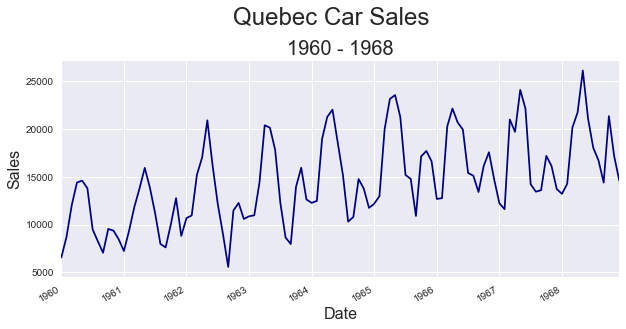

In [6]:
suptitle = 'Quebec Car Sales'
title = '1960 - 1968'

suptitle_size = 24
title_size = 20
label_size = 16

fig = plt.figure(f'{suptitle}: {title}', figsize=(10, 15),
                 facecolor='white', edgecolor='black')
rows, cols = (3, 1)
ax1 = plt.subplot2grid((rows, cols), (0, 0))

data.plot(x='date', y='sales', color='navy', legend=None, ax=ax1);

ax1.set_title(title, fontsize=title_size)
ax1.set_xlabel('Date', fontsize=label_size)
ax1.set_ylabel('Sales', fontsize=label_size)

fig.suptitle(suptitle, fontsize=suptitle_size, y=0.93)
fig.autofmt_xdate();

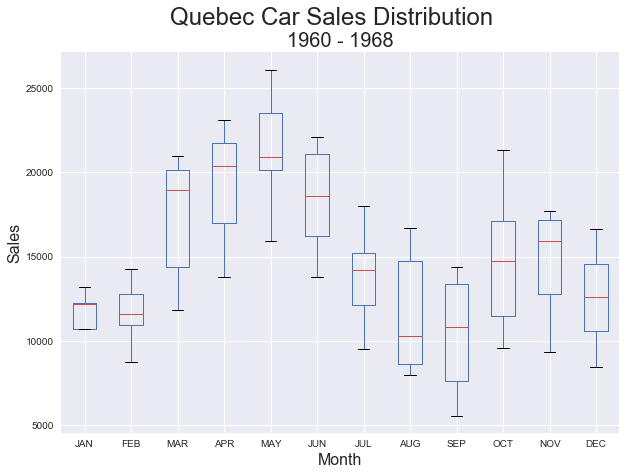

In [7]:
suptitle = 'Quebec Car Sales Distribution'
title = '1960 - 1968'

suptitle_size = 24
title_size = 20
label_size = 16

fig = plt.figure(f'{suptitle}: {title}', figsize=(10, 7),
                 facecolor='white', edgecolor='black')
rows, cols = (1, 1)
ax1 = plt.subplot2grid((rows, cols), (0, 0))

sales.plot(kind='box', ax=ax1)

ax1.set_title(title, fontsize=title_size)
ax1.set_xlabel('Month', fontsize=label_size)
ax1.set_ylabel('Sales', fontsize=label_size)

fig.suptitle(suptitle, fontsize=suptitle_size, y=0.97);

---
### Train and Test Datasets

In [8]:
test_duration = 24
train = data[0:-test_duration]
test = data[-test_duration:]

---

---
### Optimized Persistence Forcast

#### Derive Persistance Model

- prediction[n] = train[-n]

#### Make Forcast

In [9]:
scores = []
for td in range(test_duration):
    nieve = data.shift(td + 1)
    scores.append(mean_squared_error(test.sales,
                                     nieve.sales[-test_duration:])**0.5)
forcast_score = nieve.date[-test_duration:].copy().to_frame()
forcast_score['scores'] = scores

#### Plot Initial Prediction

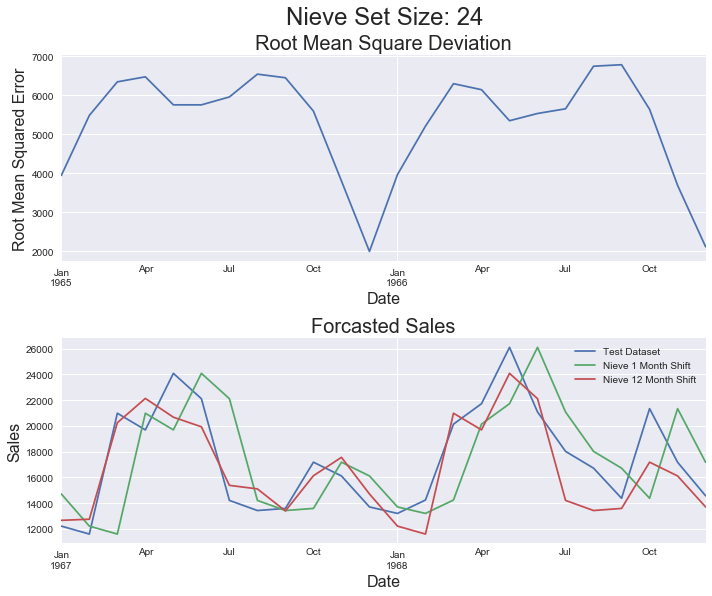

In [10]:
suptitle = f'Nieve Set Size: {test_duration}'
title = 'Root Mean Square Deviation'

suptitle_size = 24
title_size = 20
label_size = 16

fig = plt.figure(f'{suptitle}: {title}', figsize=(10, 8),
                 facecolor='white', edgecolor='black')
rows, cols = (2, 1)
ax1 = plt.subplot2grid((rows, cols), (0, 0))
ax2 = plt.subplot2grid((rows, cols), (1, 0))

forcast_score.plot(x='date', y='scores', legend=None, ax=ax1)

ax1.set_title(title, fontsize=title_size)
ax1.set_xlabel('Date', fontsize=label_size)
ax1.set_ylabel('Root Mean Squared Error', fontsize=label_size)

test.plot(x='date', y='sales', label='Test Dataset', ax=ax2)

nieve_1 = data.copy()
nieve_1.sales = nieve_1.sales.shift(1)
nieve_1[-test_duration:].plot(x='date', y='sales',
                              label='Nieve 1 Month Shift',
                              ax=ax2)

nieve_12 = data.copy()
nieve_12.sales = nieve_12.sales.shift(12)
nieve_12[-test_duration:].plot(x='date', y='sales',
                               label='Nieve 12 Month Shift',
                               ax=ax2)

ax2.set_title('Forcasted Sales', fontsize=title_size)
ax2.set_xlabel('Date', fontsize=label_size)
ax2.set_ylabel('Sales', fontsize=label_size)

fig.suptitle(suptitle, fontsize=suptitle_size, x=0.54, y=1.03)
plt.tight_layout();

#### Review and Assess 1

A cyclic pattern occurs every 12 months.
Alter the persistance model to be the average of all prior months of like kind.

In [11]:
sales_mean = sales.mean()
sales_mean.index = range(12)
sales_mean = sales_mean.append([sales_mean] * 8, ignore_index=True)

weighted_month = data.copy()
weighted_month['sales_mean'] = sales_mean

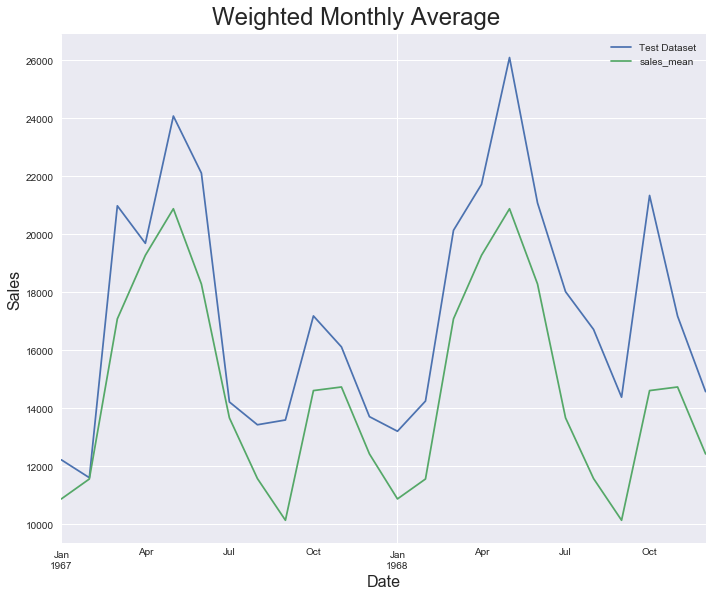

In [12]:
suptitle = 'Weighted Monthly Average'

suptitle_size = 24
label_size = 16

fig = plt.figure(f'{suptitle}', figsize=(10, 8),
                 facecolor='white', edgecolor='black')
rows, cols = (1, 1)
ax1 = plt.subplot2grid((rows, cols), (0, 0))

test.plot(x='date', y='sales', label='Test Dataset', ax=ax1)
weighted_month[-test_duration:].plot(x='date', y='sales_mean',
                                     ax=ax1)

ax1.set_xlabel('Date', fontsize=label_size)
ax1.set_ylabel('Sales', fontsize=label_size)

fig.suptitle(suptitle, fontsize=suptitle_size, y=1.03)
plt.tight_layout();

---

---
### Expanding Window Forecast

* Calculates a statistic on **all** available historic data and use that to make a forcast.
* This model grows as more real observations are collected.

In [13]:
window_mean = data.sales.expanding().mean()
window_median = data.sales.expanding().median()
window_statistics = pd.concat([data.date,
                               window_mean,
                               window_median], axis=1)
window_statistics.columns = ['date', 'win_mean', 'win_median']
window_statistics[-test_duration:]

,date,win_mean,win_median
84,1967-01-01,13773.917647,12965.0
85,1967-02-01,13748.732558,12862.5
86,1967-03-01,13831.908046,12965.0
87,1967-04-01,13898.500000,13183.0
88,1967-05-01,14012.910112,13401.0
89,1967-06-01,14102.922222,13577.5
90,1967-07-01,14104.208791,13754.0
91,1967-08-01,14096.923913,13594.0
92,1967-09-01,14091.559140,13598.0
93,1967-10-01,14124.489362,13676.0


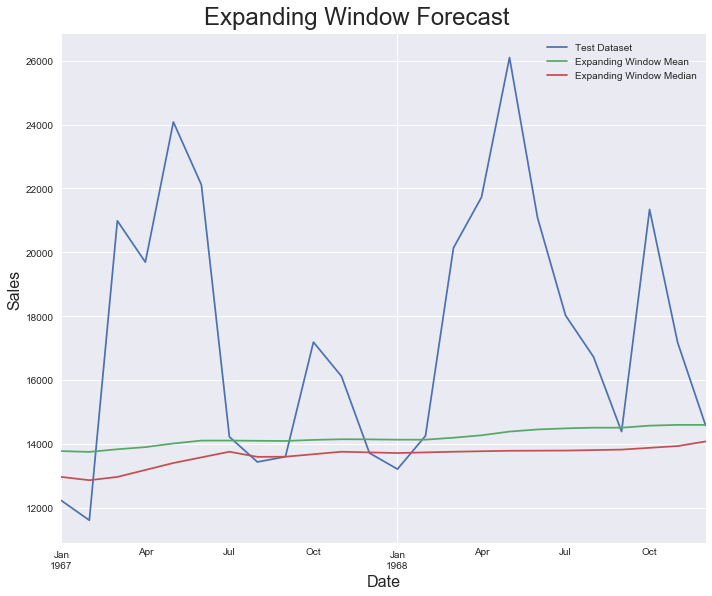

In [14]:
suptitle = 'Expanding Window Forecast'

suptitle_size = 24
label_size = 16

fig = plt.figure(f'{suptitle}', figsize=(10, 8),
                 facecolor='white', edgecolor='black')
rows, cols = (1, 1)
ax1 = plt.subplot2grid((rows, cols), (0, 0))

test.plot(x='date', y='sales', label='Test Dataset', ax=ax1)
window_statistics[-test_duration:].plot(x='date', y='win_mean',
                                        label='Expanding Window Mean',
                                        ax=ax1)
window_statistics[-test_duration:].plot(x='date', y='win_median',
                                        label='Expanding Window Median',
                                        ax=ax1)

ax1.set_xlabel('Date', fontsize=label_size)
ax1.set_ylabel('Sales', fontsize=label_size)

fig.suptitle(suptitle, fontsize=suptitle_size, y=1.03)
plt.tight_layout();

---

---
### Rolling Window Forcast

* Calculates a statistic on **n** number of historic data and use that to make a forcast.


In [15]:
rolling_mean = pd.DataFrame(data.date)
rolling_mean_error = []
rolling_median = pd.DataFrame(data.date)
rolling_median_error = []

for n in range(1, test_duration + 1):
    rolling_mean[f'rolling_{n}'] = data.sales.rolling(n).mean()
    rolling_median[f'rolling_{n}'] = data.sales.rolling(n).median()
    rolling_mean_error.append(mean_squared_error(
        test.sales, rolling_mean[f'rolling_{n}'][-test_duration - 1:-1])**0.5)
    rolling_median_error.append(mean_squared_error(
        test.sales, rolling_median[f'rolling_{n}'][-test_duration - 1:-1])**0.5)

min_mean = min(rolling_mean_error)
min_mean_idx = rolling_mean_error.index(min_mean) + 1
min_median = min(rolling_median_error)
min_median_idx = rolling_median_error.index(min_median) + 1

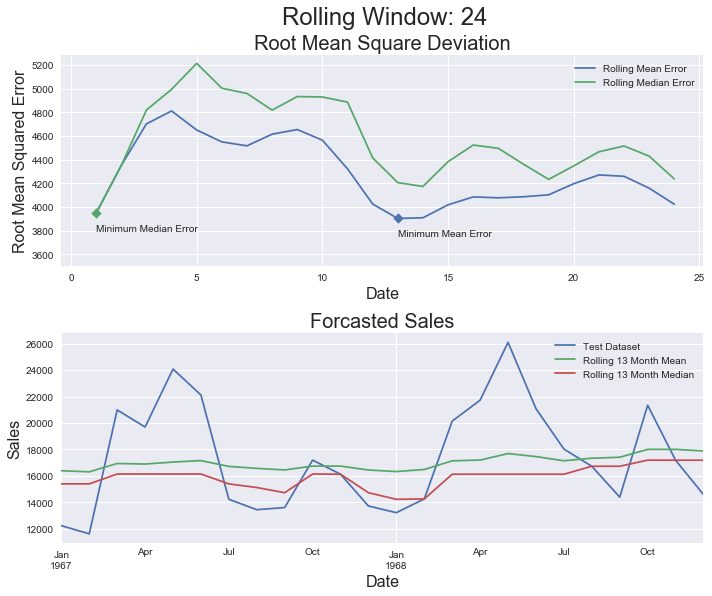

In [16]:
suptitle = f'Rolling Window: {test_duration}'
title = 'Root Mean Square Deviation'

suptitle_size = 24
title_size = 20
label_size = 16

fig = plt.figure(f'{suptitle}: {title}', figsize=(10, 8),
                 facecolor='white', edgecolor='black')
rows, cols = (2, 1)
ax1 = plt.subplot2grid((rows, cols), (0, 0))
ax2 = plt.subplot2grid((rows, cols), (1, 0))

ax1.plot(range(1, len(rolling_mean_error) + 1), rolling_mean_error,
         label='Rolling Mean Error')
ax1.plot(range(1, len(rolling_median_error) + 1), rolling_median_error,
         label='Rolling Median Error')
ax1.scatter(min_mean_idx, min_mean, marker='D')
ax1.text(min_mean_idx, min_mean - 150, 'Minimum Mean Error')
ax1.scatter(min_median_idx, min_median, marker='D')
ax1.text(min_median_idx, min_median - 150, 'Minimum Median Error')

ax1.set_title(title, fontsize=title_size)
ax1.legend()
ax1.set_xlabel('Date', fontsize=label_size)
ax1.set_ylabel('Root Mean Squared Error', fontsize=label_size)
ax1_xmin, ax1_xmax, ax1_ymin, ax1_ymax = ax1.axis()
ax1.axis((ax1_xmin, ax1_xmax, 3500, ax1_ymax))

test.plot(x='date', y='sales', label='Test Dataset', ax=ax2)

rolling_mean[-test_duration:].plot(x='date', y='rolling_13',
                                   label='Rolling 13 Month Mean',
                                   ax=ax2)
                                    
rolling_median[-test_duration:].plot(x='date', y='rolling_13',
                                     label='Rolling 13 Month Median',
                                     ax=ax2)

ax2.set_title('Forcasted Sales', fontsize=title_size)
ax2.set_xlabel('Date', fontsize=label_size)
ax2.set_ylabel('Sales', fontsize=label_size)

fig.suptitle(suptitle, fontsize=suptitle_size, x=0.54, y=1.03)
plt.tight_layout();